# Titanic (Top 13%, 0.78708 Accuracy)

## Importing The Libraries

In [140]:
import pandas as pd
import numpy as np

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [142]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [143]:
import warnings
warnings.filterwarnings("ignore")

## The Dataset

### Reading The Data

In [144]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [145]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Getting The General Information About The Data

In [146]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Descriptive Statistics

In [147]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Checking The Missing Values In The Dataset

In [148]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [149]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### Replacing The Missing Values In Embarked By The Mode Of The Column

In [150]:
embarked_mode = train["Embarked"].mode()[0]

In [151]:
train["Embarked"].fillna(embarked_mode, inplace=True)

#### Creating A New Column Indicating Whether Cabin Information Was Missing Or Not And Dropping The Cabin Column

In [152]:
train["Cabin_Missing"] = train["Cabin"].map(lambda x: 1 if pd.isnull(x) else 0)
train.drop("Cabin", axis=1, inplace=True)

In [153]:
test["Cabin_Missing"] = test["Cabin"].map(lambda x: 1 if pd.isnull(x) else 0)
test.drop("Cabin", axis=1, inplace=True)

#### Deal With The Missing Values In Age Column

In [154]:
age_medians = train.groupby(by=["Sex", "Pclass", "Embarked"])["Age"].median()

In [155]:
for sex in ["female", "male"]:
    for pclass in [1,2,3]:
        for emb in ["C", "Q", "S"]:
            mask = (train["Sex"]==sex) & (train["Pclass"]==pclass) & (train["Embarked"]==emb)
            train["Age"].loc[mask] = train["Age"].loc[mask].fillna(age_medians[sex, pclass, emb])
            
            mask = (test["Sex"]==sex) & (test["Pclass"]==pclass) & (test["Embarked"]==emb)
            test["Age"].loc[mask] = test["Age"].loc[mask].fillna(age_medians[sex, pclass, emb])

#### Replacing The Missing Values In Fare Column By The Median

In [156]:
fare_median = train["Fare"].median()

In [157]:
test["Fare"].fillna(fare_median, inplace=True)

#### Checking For The Missing Values Once Again

In [158]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Missing    0
dtype: int64

In [159]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Missing    0
dtype: int64

As we can see, we do not have any missing value now.

## Data Wrangling

### Title Column  

We will get the titles of all the names and drop the Name column

In [160]:
train["Title"] = train["Name"].apply(lambda x: x.split()[1])
train["Title"].value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Planke,           3
Impe,             3
Gordon,           2
Col.              2
Major.            2
Mlle.             2
Messemaeker,      1
der               1
Pelsmaeker,       1
Steen,            1
Shawah,           1
Velde,            1
Mme.              1
Jonkheer.         1
Don.              1
Walle,            1
Cruyssen,         1
Ms.               1
Mulder,           1
Melkebeke,        1
the               1
Carlo,            1
Billiard,         1
Capt.             1
Name: Title, dtype: int64

We can see that apart from Mr., Miss., Mrs., Master. all others titles are very less in occurence. So we will group them together into 'Others'

In [161]:
titles = train["Title"].value_counts().index.tolist()
for title in titles[4:]:
    train["Title"].replace(title, "Others", inplace=True)

In [162]:
train.drop("Name", axis=1, inplace=True)

In [163]:
test["Title"] = test["Name"].apply(lambda x: x.split()[1])
test["Title"].value_counts()

Mr.             234
Miss.            77
Mrs.             70
Master.          19
y                 4
Rev.              2
Billiard,         2
Col.              2
Planke,           1
Carlo,            1
Dr.               1
Brito,            1
Ms.               1
Palmquist,        1
Khalil,           1
Messemaeker,      1
Name: Title, dtype: int64

In [164]:
titles = test["Title"].value_counts().index.tolist()
for title in titles[4:]:
    test["Title"].replace(title, "Others", inplace=True)

In [165]:
test.drop("Name", axis=1, inplace=True)

### Family Members Column

We will combine the SibSp and Parch columns into one column and drop the SibSp and Parch columns

In [166]:
train["FamilyMembers"] = train["SibSp"] + train["Parch"]
train.drop(["SibSp", "Parch"], axis=1, inplace=True)

In [167]:
test["FamilyMembers"] = test["SibSp"] + test["Parch"]
test.drop(["SibSp", "Parch"], axis=1, inplace=True)

### Categorizing Age Column

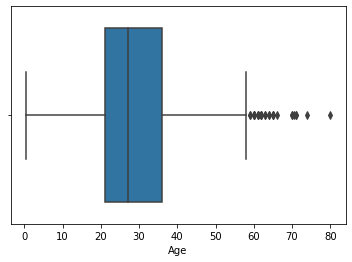

In [168]:
sns.boxplot(train["Age"])
plt.show()

In [169]:
train["AgeGroup"] = pd.cut(train["Age"], bins=[0,18,30,60,100], labels=["Young", "Young Adult", "Adult", "Old"], include_lowest=True)
train.drop("Age", axis=1, inplace=True)

test["AgeGroup"] = pd.cut(test["Age"], bins=[0,18,30,60,100], labels=["Young", "Young Adult", "Adult", "Old"], include_lowest=True)
test.drop("Age", axis=1, inplace=True)

### Categorizing Fare Column

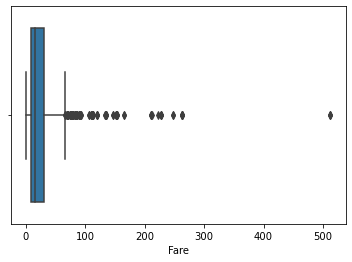

In [170]:
sns.boxplot(train["Fare"])
plt.show()

In [171]:
train["FareGroup"] = pd.cut(train["Fare"], bins=[0,20,50,100,1000], labels=["0-20", "21-50", "51-100", "100+"], include_lowest=True)
train.drop("Fare", axis=1, inplace=True)

test["FareGroup"] = pd.cut(test["Fare"], bins=[0,20,50,100,1000], labels=["0-20", "21-50", "51-100", "100+"], include_lowest=True)
test.drop("Fare", axis=1, inplace=True)

### Categorizing Family Members Column

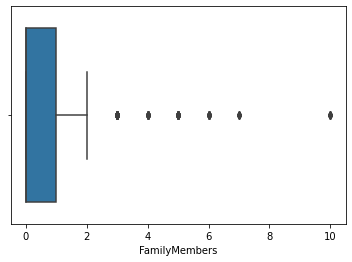

In [172]:
sns.boxplot(train["FamilyMembers"])
plt.show()

In [173]:
train["FamilySize"] = pd.cut(train["FamilyMembers"], bins=[0,1,4,6,20], labels=["Alone", "Small", "Medium", "Large"], include_lowest=True)
train.drop("FamilyMembers", axis=1, inplace=True)

test["FamilySize"] = pd.cut(test["FamilyMembers"], bins=[0,1,4,6,20], labels=["Alone", "Small", "Medium", "Large"], include_lowest=True)
test.drop("FamilyMembers", axis=1, inplace=True)

#### Dropping The Ticket Column

In [174]:
train.drop("Ticket", axis=1, inplace=True)
test.drop("Ticket", axis=1, inplace=True)

#### Checking All The Columns

In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Sex            891 non-null    object  
 4   Embarked       891 non-null    object  
 5   Cabin_Missing  891 non-null    int64   
 6   Title          891 non-null    object  
 7   AgeGroup       891 non-null    category
 8   FareGroup      891 non-null    category
 9   FamilySize     891 non-null    category
dtypes: category(3), int64(4), object(3)
memory usage: 52.0+ KB


In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    418 non-null    int64   
 1   Pclass         418 non-null    int64   
 2   Sex            418 non-null    object  
 3   Embarked       418 non-null    object  
 4   Cabin_Missing  418 non-null    int64   
 5   Title          418 non-null    object  
 6   AgeGroup       418 non-null    category
 7   FareGroup      418 non-null    category
 8   FamilySize     418 non-null    category
dtypes: category(3), int64(3), object(3)
memory usage: 21.5+ KB


## Exploratory Data Analysis

In [177]:
# Helper Method To Display Count Plot

def show_count_plot(x, hue=None, data=train):
    plt.figure()
    sns.countplot(x, hue=hue, data=data)
    plt.show()

In [178]:
# Helper Method To Display Bar Plot

def show_bar_plot(x, y, data=train):
    plt.figure()
    sns.barplot(x, y, data=data, ci=None)
    plt.show()

### Let Us Check For Data Imbalance

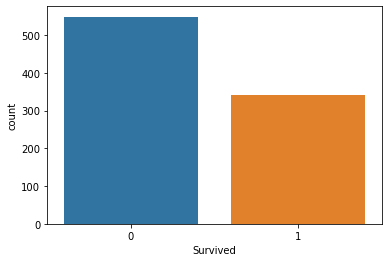

In [179]:
show_count_plot("Survived")

### Bivariate Analyis

#### Sex vs Survived

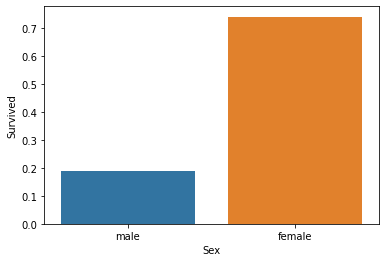

In [180]:
show_bar_plot("Sex", "Survived")

#### CabinMissing vs Survived

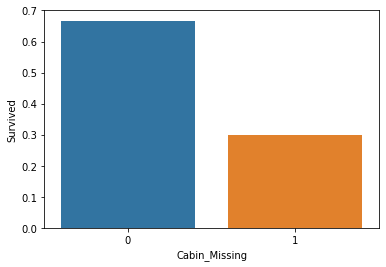

In [181]:
show_bar_plot("Cabin_Missing", "Survived")

#### Pclass vs Survived

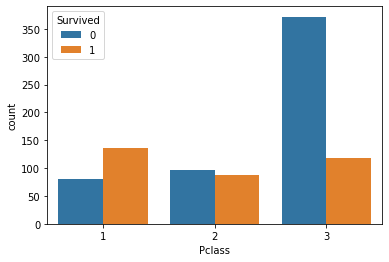

In [182]:
show_count_plot(x="Pclass", hue="Survived")

#### Embarked vs Survived

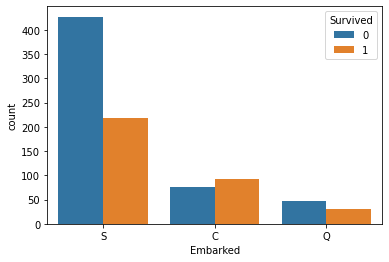

In [183]:
show_count_plot(x="Embarked", hue="Survived")

#### Title vs Survived

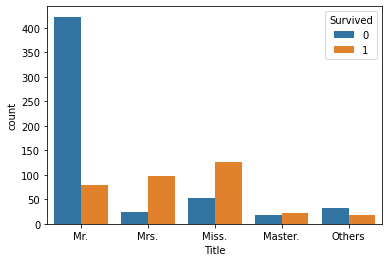

In [184]:
show_count_plot(x="Title", hue="Survived")

#### AgeGroup vs Survived

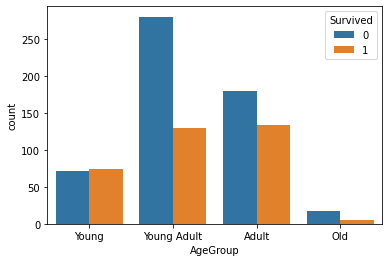

In [185]:
show_count_plot(x="AgeGroup", hue="Survived")

#### FareGroup vs Survived

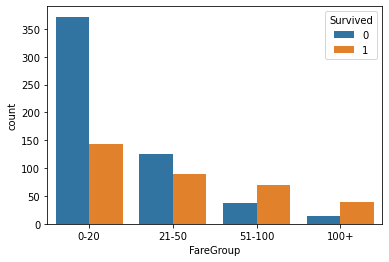

In [186]:
show_count_plot(x="FareGroup", hue="Survived")

#### FamilySize vs Survived

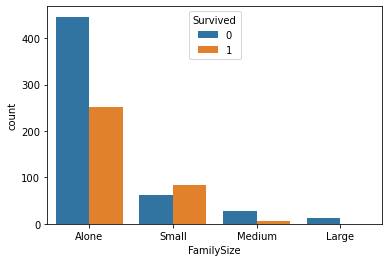

In [187]:
show_count_plot(x="FamilySize", hue="Survived")

### Multivariate Analysis

In [188]:
#Helper Method To Display Multivariate Analysis

def multivariate_analysis(index, column):
    pt = pd.pivot_table(data=train, index=index, columns=column, values="Survived")
    plt.figure()
    sns.heatmap(pt, annot=True, fmt=".2%", cmap="Greens")
    plt.show()

#### Pclass vs Sex

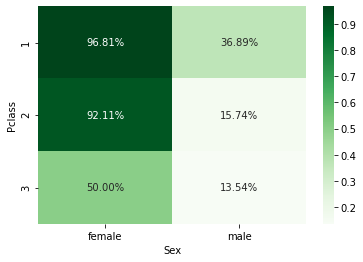

In [189]:
multivariate_analysis("Pclass", "Sex")

Females in the 1st & 2nd class have very high rates of survival

#### Pclass vs Title

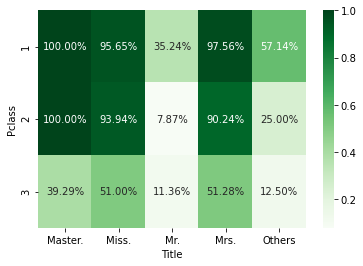

In [190]:
multivariate_analysis("Pclass", "Title")

People with title Master. in the 1st and the 2nd class have very high rates of survival

#### Sex vs FamilySize

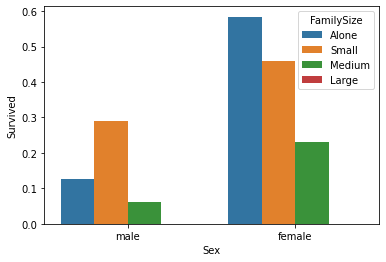

In [191]:
sns.barplot(data=train.loc[train["Pclass"]==3], x="Sex", y="Survived", hue="FamilySize", ci=None)
plt.show()

Females who are alone in class 3 have very high rates of survival

#### Sex vs Embarking Station

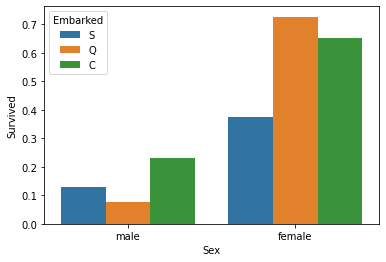

In [192]:
sns.barplot(data=train.loc[train["Pclass"]==3], x="Sex", y="Survived", hue="Embarked", ci=None)
plt.show()

Females who embarked from station C have very high rates of survival

#### Model Rules

We build a model on 5 rules :
1. All females in classes 1 and 2 survive
2. All Masters. in classes 1 and 2 survive
3. Females in class 3 who are alone survive
4. Females in class 3 who embarked from stations Q and C survive
5. All others die

## Model Building

### Creating The Train-Test Split

In [193]:
y = train.pop("Survived")
X = train

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### Coding The Model Rules

In [195]:
def make_predictions(test):
    test["Survived"] = 0
    test.loc[(test["Sex"]=="female") & (test["Pclass"]<3), "Survived"] = 1
    test.loc[(test["Title"]=="Master.") & (test["Pclass"]<3), "Survived"] = 1
    test.loc[(test["Sex"]=="female") & (test["Pclass"]==3) & (test["Embarked"]!="S"), "Survived"] = 1
    test.loc[(test["Sex"]=="female") & (test["Pclass"]==3) & (test["FamilySize"]==1), "Survived"] = 1                 

In [196]:
make_predictions(X_test)

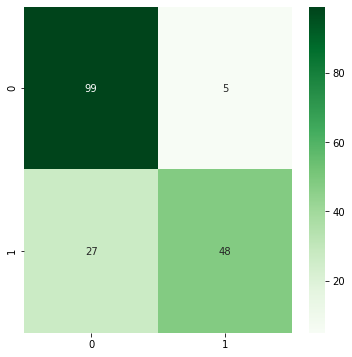

Training Accuracy : 0.82


In [197]:
plt.figure(figsize=(6,6))
cm = confusion_matrix(y_test, X_test["Survived"])
sns.heatmap(cm, annot=True, cmap="Greens")
plt.show()

train_score = np.round(accuracy_score(y_test, X_test["Survived"]),2)
print("Training Accuracy : {}".format(train_score))

### Making The Predictions On The Test Set

In [198]:
make_predictions(test)

In [199]:
submission = test[["PassengerId", "Survived"]]
submission.set_index('PassengerId',inplace=True)
submission.to_csv('submission.csv')